The problem in this project is trying to figure out if a user’s tweet indicates if a disaster is taking place somewhere or not. The task is to let the machine learn to predict efficiently the nature of the tweet either disastrous or not. It is a binary classification problem.

This notebook is focussed on Data Wrangling. The steps taken in Data Wrangling process are:

1. Looking for missing values

2. Checking Duplicates

3. Checking the Target balance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re #Regular Expressions
import string #importing string functions
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.porter import PorterStemmer

In [3]:
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,MaxPooling1D,Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc

In [4]:
perfect_submission = pd.read_csv(
    "https://raw.githubusercontent.com/mitramir55/Kaggle_NLP_competition/master/perfect_submission.csv"
    , sep=",")    # provides the correct targets for test set

In [5]:
train = pd.read_csv("/Users/amrita/Desktop/train.csv", sep=",") 
test = pd.read_csv('/Users/amrita/Desktop/test .csv', sep=",")

In [6]:
test["target"] = perfect_submission["target"]

test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [7]:
test

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [8]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


The data is already split into test and train sets. Data size is 10876 records in total; 7613 in the training set and 3263 in the testing set. Train and test sets contain these columns:

id:- a unique identifier for each tweet.

text:- the text of the tweet.

location:- the tweet location (may be blank).

keyword:- tweet search keyword (may be blank).

In [9]:
data = train.append(test)
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


# Check Missing Values

In [10]:
data=data.replace(r'^\s*$', np.NaN, regex=True)

In [11]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_data = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_data

,column_name,percent_missing
id,id,0.000000
keyword,keyword,0.799926
location,location,33.468187
text,text,0.000000
target,target,0.000000


No missing values in Id, text and target columns.

33% of location values are missing.

0.007% values are missing in keywords.

We will drop 'location'.

In [12]:
data= data.drop('location', axis=1)

In [13]:
data

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
3258,10861,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
3259,10865,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [14]:
data.tail(300)

,id,keyword,text,target
2963,9807,trapped,Ghost is literally surrounded by people who ar...,0
2964,9809,trauma,Students suffering from trauma ÛÓ like divorc...,0
2965,9811,trauma,RT MME_AUSTIN: Why #Marijuana Is Critical For ...,0
2966,9814,trauma,sickmund: RT NCJFCJ: #NCJFCJ President Judge B...,0
2967,9817,trauma,What I Learned About Fat Dating Trauma Through...,0
...,...,...,...,...
3258,10861,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
3259,10865,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


# Check Duplicates

In [15]:
data= data.drop_duplicates()

# Check Target Balance

In [16]:
data['target'].value_counts()

0    6203
1    4673
Name: target, dtype: int64

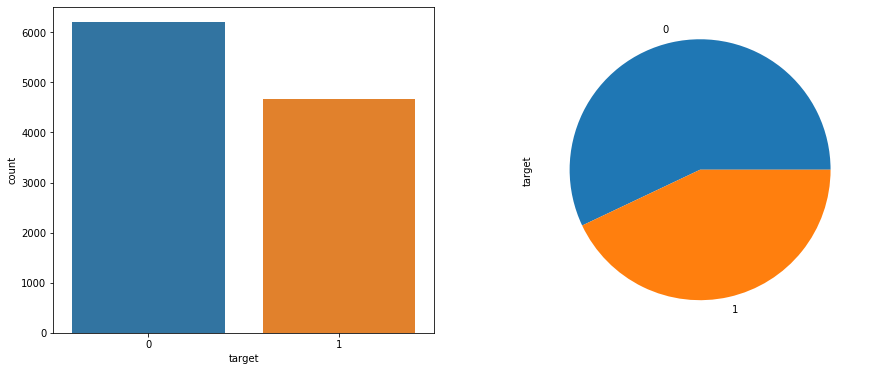

In [17]:
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=data['target'])
plt.subplot(1, 2, 2)
data['target'].value_counts().plot.pie(y='Class')

From the above plots, it can be observed that the total number of samples in Target Class 1 is 4673 while in Target Class 0, it is about 6203. We can overcome the target balance using downsampling. 